In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/Colab Notebooks/COSE474/FinalProject/20242R0136COSE47402

/content/drive/MyDrive/Colab Notebooks/COSE474/FinalProject/20242R0136COSE47402/FinalProject


In [33]:
ls

captions_val2017.json  sample_image.png  self_attention_layer1_forward.py  TestCode.ipynb


# Preparation

In [ ]:
import json
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

##Loading CLIP model
Training 없이 모델 구조 기반의 inference 실험을 할 것이기에 가장 작은 모델 사용.
CLIP 자체로는 이미지 caption을 생성하지 않기에 image captioning model을 추가로 사용.

In [20]:
from PIL import Image
import requests
from transformers import CLIPProcessor, CLIPModel, VisionEncoderDecoderModel, AutoTokenizer

# Load the CLIP model and processor
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch16")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch16")

# Load the image captioning model
caption_model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
caption_tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.46.2"
}

Config of the decoder: <class 'transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel'> is overwritten by shared decoder config: GPT2Config {
  "activation_function": "gelu_new",
  "add_cross_attention": true,
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "decoder_start_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_rang

## Fetching Cat and Dog images from MSCOCO dataset
instances_val2027.json으로부터 얻은 강아지와 고양이의 id로 강아지와 고양이 이미지만 뽑기

In [44]:
## fetch cat&dog images from MSCOCO
mscoco_instances_path = "instances_val2017.json"
mscoco_captions_path = "captions_val2017.json"

# 강아지와 고양이의 category_id
target_categories = {17: "cat", 18: "dog"}

# 필터링된 이미지 ID 저장
target_image_ids = set()

# Load instances JSON to filter images
with open(mscoco_instances_path, "r") as f:
    instances_data = json.load(f)

# Annotation에서 강아지와 고양이가 포함된 이미지 필터링
for annotation in instances_data["annotations"]:
    if annotation["category_id"] in target_categories:
        target_image_ids.add(annotation["image_id"])

total_images = len(target_image_ids)
print(f"Number of images with cats or dogs: {total_images}")

# Load captions JSON
with open(mscoco_captions_path, "r") as f:
    captions_data = json.load(f)

# Extract image and caption information
images_info = {img["id"]: img for img in captions_data["images"]}
annotations = captions_data["annotations"]

# Group captions by image ID
captions_by_image = {}
for ann in annotations:
    if ann["image_id"] in target_image_ids:  # Filter only target image IDs
        captions_by_image.setdefault(ann["image_id"], []).append(ann["caption"])
print(captions_by_image)

Number of images with cats or dogs: 349
{46378: ['A cat eating a bird it has caught.', 'A white cat caught a bird outside on a patio.', 'Grey house cat devours a song bird on a door step', 'A long haired cat eating a dead bird.', 'A cat eating a dead bird on the ground.'], 172330: ['A cat in between two cars in a parking lot.', 'A cat stands between two parked cars on a grassy sidewalk. ', 'A cat at attention between two parked cars.', 'A grey and white cat watches from between parked cars.', 'A grey and white cat standing in the grass in a parking lot. '], 223747: ['a man sleeping with his cat next to him', 'A young man and his cute cat enjoy a nap together.', 'A man is sleeping with his head on a pillow.', 'Man sleeping in his bedroom next to a cat.', 'Man sleeping next to a cat on a bed. '], 482917: ['A dog sitting between its masters feet on a footstool watching tv\n', 'A dog between the feet of a person looking at a TV.', 'A dog and a person are watching television together.', 'A 

#**Original CLIP**


### MSCOCO Dataset 결과

In [ ]:
# Initialize variables for average score calculation
total_similarity_score = 0.0
processed_images = 0
num_images = 50  # Number of images to process (adjust as needed)

# Candidate captions
# candidate_captions = ["a photo of a cat", "a photo of a dog", "a photo of an animal"]
candidate_captions = ["a photo of a white cat", "a photo of a black cat", "a photo of a white dog", "a photo of a black dog","a photo of an animal"]

# Loop through filtered images
for image_id, captions in list(captions_by_image.items())[:num_images]:
    # Load image from URL
    image_url = images_info[image_id]["coco_url"]
    print(image_url)
    image = Image.open(requests.get(image_url, stream=True).raw).convert("RGB")

    plt.imshow(image)
    plt.title(f"Image ID: {image_id}")
    plt.axis("off")
    plt.show()

    # CLIP score for candidate captions
    inputs = clip_processor(text=candidate_captions, images=image, return_tensors="pt", padding=True)
    outputs = clip_model(**inputs)

    # Compute similarity scores
    logits_per_image = outputs.logits_per_image
    print(logits_per_image)
    probs = logits_per_image.softmax(dim=1)
    best_caption_index = torch.argmax(probs).item()
    best_caption = candidate_captions[best_caption_index]
    print(f"Best caption by CLIP for image {image_id}: {best_caption}")

    # Calculate CLIP similarity score for best caption
    pixel_values = clip_processor(images=image, return_tensors="pt").pixel_values
    image_features = clip_model.get_image_features(pixel_values)

    text_inputs = clip_processor(text=[best_caption], return_tensors="pt", padding=True)
    text_features = clip_model.get_text_features(**text_inputs)

    # Normalize embeddings
    image_features = F.normalize(image_features, p=2, dim=1)
    text_features = F.normalize(text_features, p=2, dim=1)

    # Cosine similarity
    similarity_score = (image_features @ text_features.T).item()
    print(f"CLIP Similarity Score for image {image_id}: {similarity_score}")

    # Generate a detailed caption using the captioning model
    pixel_values = clip_processor(images=image, return_tensors="pt").pixel_values
    attention_mask = torch.ones(pixel_values.shape[:2], dtype=torch.long)

    generated_ids = caption_model.generate(
        pixel_values,
        attention_mask=attention_mask,  # Explicitly pass the attention mask
        max_length=50,                 # Set a custom maximum length for the output
        pad_token_id=caption_tokenizer.pad_token_id  # Use the tokenizer's pad token ID
    )
    generated_caption = caption_tokenizer.decode(generated_ids[0], skip_special_tokens=True)
    print(f"Generated Caption: {generated_caption}")

    # CLIP의 Best Caption을 Caption Generation 모델의 입력에 포함
    best_caption = candidate_captions[best_caption_index]
    input_ids = caption_tokenizer(best_caption, return_tensors="pt").input_ids

    generated_ids = caption_model.generate(
        pixel_values,
        input_ids=input_ids,  # CLIP의 Best Caption 반영
        attention_mask=attention_mask,
        max_length=50,
        pad_token_id=caption_tokenizer.pad_token_id
    )
    generated_caption = caption_tokenizer.decode(generated_ids[0], skip_special_tokens=True)
    print(f"Generated Caption with CLIP influence: {generated_caption}\n")

    # Update total score and processed image count
    total_similarity_score += similarity_score
    processed_images += 1

# Calculate and print the average CLIP similarity score
average_similarity_score = total_similarity_score / processed_images
print(f"\nAverage CLIP Similarity Score for {processed_images} images: {average_similarity_score}")


### Test on single image

In [113]:
# load image
# url = "http://images.cocodataset.org/val2017/000000039769.jpg"
# url = "http://images.cocodataset.org/val2017/000000227044.jpg"
url = "http://images.cocodataset.org/val2017/000000284623.jpg"
image = Image.open(requests.get(url, stream=True).raw)

# Use CLIP to compute similarity scores for predefined captions
# candidate_captions = ["a photo of a cat", "a photo of a dog", "a photo of an animal"]
# candidate_captions = ["a photo of a cat", "a photo of a white cat", "a photo of a white cloud", "a photo of a black cloud"]
candidate_captions = ["a photo of a cat", "a photo of a black cat", "a photo of a black car"]
inputs = clip_processor(text=candidate_captions, images=image, return_tensors="pt", padding=True)
outputs = clip_model(**inputs)


# Get the similarity scores
logits_per_image = outputs.logits_per_image
print(logits_per_image)
probs = logits_per_image.softmax(dim=1)
best_caption_index = torch.argmax(probs).item()
print(f"Best caption by CLIP: {candidate_captions[best_caption_index]}")


# Generate a detailed caption using the captioning model
pixel_values = clip_processor(images=image, return_tensors="pt").pixel_values
attention_mask = torch.ones(pixel_values.shape[:2], dtype=torch.long)

generated_ids = caption_model.generate(
    pixel_values,
    attention_mask=attention_mask,  # Explicitly pass the attention mask
    max_length=50,                 # Set a custom maximum length for the output
    pad_token_id=caption_tokenizer.pad_token_id  # Use the tokenizer's pad token ID
)
generated_caption = caption_tokenizer.decode(generated_ids[0], skip_special_tokens=True)
print(f"Generated Caption: {generated_caption}")


# CLIP의 Best Caption을 Caption Generation 모델의 입력에 포함
best_caption = candidate_captions[best_caption_index]
input_ids = caption_tokenizer(best_caption, return_tensors="pt").input_ids

generated_ids = caption_model.generate(
    pixel_values,
    input_ids=input_ids,  # CLIP의 Best Caption 반영
    attention_mask=attention_mask,
    max_length=50,
    pad_token_id=caption_tokenizer.pad_token_id
)
generated_caption = caption_tokenizer.decode(generated_ids[0], skip_special_tokens=True)
print(f"Generated Caption with CLIP influence: {generated_caption}")

tensor([[26.8981, 29.5249, 22.4578]], grad_fn=<TBackward0>)
Best caption by CLIP: a photo of a black cat
Generated Caption: a cat sitting on a sink next to a mirror 
Generated Caption with CLIP influence: a photo of a black cat sitting on a sink 


### 생성된 caption에 대해 CLIP score 계산

In [22]:
# 이미지 임베딩 생성
pixel_values = clip_processor(images=image, return_tensors="pt").pixel_values
image_features = clip_model.get_image_features(pixel_values)

# 캡션 임베딩 생성
print(generated_caption)
text_inputs = clip_processor(text=[generated_caption], return_tensors="pt", padding=True)
text_features = clip_model.get_text_features(**text_inputs)

# 임베딩 정규화 (벡터 길이를 1로 만듦)
image_features = F.normalize(image_features, p=2, dim=1)
text_features = F.normalize(text_features, p=2, dim=1)

# 유사도 점수 계산 (코사인 유사도)
similarity_score = (image_features @ text_features.T).item()
print(f"CLIP Similarity Score: {similarity_score}")

a photo of a cat and a cat laying on a blanket 
CLIP Similarity Score: 0.267513632774353


# CLIP model 수정

In [7]:
clip_model

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e

In [16]:
for name, module in clip_model.named_modules():
  print(name, module)

 CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1

### CLIP vision model의 self attention layer 속 forward 함수 코드 얻기

In [16]:
self_attn_layer1 = clip_model.vision_model.encoder.layers[0].self_attn
print(self_attn_layer1)

# k_proj와 q_proj 확인
print("Key Projection:", self_attn_layer1.k_proj)
print("Query Projection:", self_attn_layer1.q_proj.weight)

# Forward 함수 확인
import inspect
forward_code = inspect.getsource(self_attn_layer1.forward)
print(forward_code)

# 파일에 저장
file_name = "self_attention_layer1_forward.py"
with open(file_name, "w") as f:
    f.write(forward_code)

print(f"Forward code saved to {file_name}")

###Self Attention Layer의 forward 함수 수정

attention layer의 query, key 부분을 identity matrix로 대체.
이로 인해 output은 value값이 그대로 반영됨

In [23]:
from typing import Optional, Tuple
from types import MethodType
from packaging import version
is_torch_greater_or_equal_than_2_2 = version.parse(torch.__version__) >= version.parse("2.2.0")


def forward_modified(
    self,
    hidden_states: torch.Tensor,
    attention_mask: Optional[torch.Tensor] = None,
    causal_attention_mask: Optional[torch.Tensor] = None,
    output_attentions: Optional[bool] = False,
) -> Tuple[torch.Tensor, Optional[torch.Tensor]]:
    if output_attentions:
        # TODO: Improve this warning with e.g. `model.config.attn_implementation = "manual"` once this is implemented.
        logger.warning_once(
            "CLIPModel is using CLIPSdpaAttention, but `torch.nn.functional.scaled_dot_product_attention` does not "
            "support `output_attentions=True`. Falling back to the manual attention implementation, but specifying "
            "the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can "
            'be removed using the argument `attn_implementation="eager"` when loading the model.'
        )
        return super().forward(
            hidden_states=hidden_states,
            attention_mask=attention_mask,
            causal_attention_mask=causal_attention_mask,
            output_attentions=output_attentions,
        )

    # CLIP text model uses both `causal_attention_mask` and `attention_mask`
    if attention_mask is not None and causal_attention_mask is not None:
        attn_mask = attention_mask + causal_attention_mask
    elif causal_attention_mask is not None:
        attn_mask = causal_attention_mask
    else:
        attn_mask = attention_mask

    bsz, tgt_len, embed_dim = hidden_states.size()

    query_states = self.q_proj(hidden_states)
    key_states = self.k_proj(hidden_states)
    value_states = self.v_proj(hidden_states)


    # print(query_states.size())
    # print(key_states.size())
    # print(value_states.size())


    query_states = query_states.view(bsz, -1, self.num_heads, self.head_dim).transpose(1, 2)
    key_states = key_states.view(bsz, -1, self.num_heads, self.head_dim).transpose(1, 2)
    value_states = value_states.view(bsz, -1, self.num_heads, self.head_dim).transpose(1, 2)

    # SDPA with memory-efficient backend is currently (torch==2.1.2) bugged with non-contiguous inputs with custom attn_mask,
    # Reference: https://github.com/pytorch/pytorch/issues/112577.
    if not is_torch_greater_or_equal_than_2_2 and query_states.device.type == "cuda" and attn_mask is not None:
        query_states = query_states.contiguous()
        key_states = key_states.contiguous()
        value_states = value_states.contiguous()

    # CLIP text model uses both `causal_attention_mask` and `attention_mask` sequentially.
    '''attn_output = torch.nn.functional.scaled_dot_product_attention(
        query_states,
        key_states,
        value_states,
        attn_mask=attn_mask,
        dropout_p=self.dropout if self.training else 0.0,
        scale=self.scale,
    )'''
    attn_output = value_states ## 수정
    attn_output = attn_output.transpose(1, 2)
    attn_output = attn_output.reshape(bsz, tgt_len, embed_dim)

    attn_output = self.out_proj(attn_output)

    return attn_output, None

#**Modified CLIP**

In [220]:
# Load the CLIP model and processor
modified_clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch16")
modified_clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch16")

In [222]:
# 수정된 forward 함수를 Layer들에 적용 [customize!!]
for i in range(0,12):
  self_attn_layer_i = modified_clip_model.vision_model.encoder.layers[i].self_attn
  self_attn_layer_i.forward = MethodType(forward_modified, self_attn_layer_i)

### MSCOCO Dataset 결과

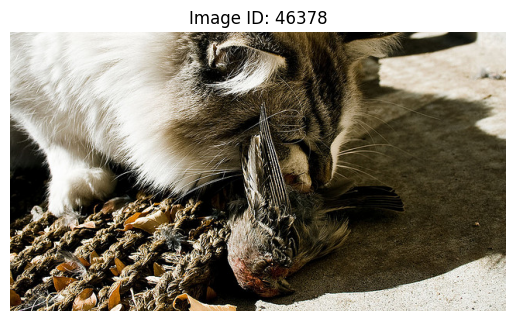

tensor([[21.9081, 24.1195, 24.9565, 22.8555]], grad_fn=<TBackward0>)
Best caption by CLIP for image 46378: a photo of an animal


KeyboardInterrupt: 

In [88]:
import matplotlib.pyplot as plt

# Initialize variables for average score calculation
total_similarity_score = 0.0
processed_images = 0
num_images = 10  # Number of images to process (adjust as needed)

# Candidate captions
candidate_captions = ["a photo of a cat", "a photo of a dog", "a photo of an animal", "a photo of a chair"]

# Loop through filtered images
for image_id, captions in list(captions_by_image.items())[:num_images]:
    # Load image from URL
    image_url = images_info[image_id]["coco_url"]
    image = Image.open(requests.get(image_url, stream=True).raw).convert("RGB")

    plt.imshow(image)
    plt.title(f"Image ID: {image_id}")
    plt.axis("off")
    plt.show()

    # CLIP score for candidate captions
    inputs = modified_clip_processor(text=candidate_captions, images=image, return_tensors="pt", padding=True)
    outputs = modified_clip_model(**inputs)

    # Compute similarity scores
    logits_per_image = outputs.logits_per_image
    print(logits_per_image)
    probs = logits_per_image.softmax(dim=1)
    best_caption_index = torch.argmax(probs).item()
    best_caption = candidate_captions[best_caption_index]
    print(f"Best caption by CLIP for image {image_id}: {best_caption}")

    # Calculate CLIP similarity score for best caption
    pixel_values = clip_processor(images=image, return_tensors="pt").pixel_values
    image_features = clip_model.get_image_features(pixel_values)

    text_inputs = clip_processor(text=[best_caption], return_tensors="pt", padding=True)
    text_features = clip_model.get_text_features(**text_inputs)

    # Normalize embeddings
    image_features = F.normalize(image_features, p=2, dim=1)
    text_features = F.normalize(text_features, p=2, dim=1)

    # Cosine similarity
    similarity_score = (image_features @ text_features.T).item()
    print(f"CLIP Similarity Score for image {image_id}: {similarity_score}")

    # Generate a detailed caption using the captioning model
    pixel_values = modified_clip_processor(images=image, return_tensors="pt").pixel_values
    attention_mask = torch.ones(pixel_values.shape[:2], dtype=torch.long)

    generated_ids = caption_model.generate(
        pixel_values,
        attention_mask=attention_mask,  # Explicitly pass the attention mask
        max_length=50,                 # Set a custom maximum length for the output
        pad_token_id=caption_tokenizer.pad_token_id  # Use the tokenizer's pad token ID
    )
    generated_caption = caption_tokenizer.decode(generated_ids[0], skip_special_tokens=True)
    print(f"Generated Caption: {generated_caption}")

    # CLIP의 Best Caption을 Caption Generation 모델의 입력에 포함
    best_caption = candidate_captions[best_caption_index]
    input_ids = caption_tokenizer(best_caption, return_tensors="pt").input_ids

    generated_ids = caption_model.generate(
        pixel_values,
        input_ids=input_ids,  # CLIP의 Best Caption 반영
        attention_mask=attention_mask,
        max_length=50,
        pad_token_id=caption_tokenizer.pad_token_id
    )
    generated_caption = caption_tokenizer.decode(generated_ids[0], skip_special_tokens=True)
    print(f"Generated Caption with CLIP influence: {generated_caption}\n")

    # Update total score and processed image count
    total_similarity_score += similarity_score
    processed_images += 1

# Calculate and print the average CLIP similarity score
average_similarity_score = total_similarity_score / processed_images
print(f"\nAverage CLIP Similarity Score for {processed_images} images: {average_similarity_score}")


### Test on single image

In [223]:
# Use CLIP to compute similarity scores for predefined captions
# candidate_captions = ["a photo of a cat", "a photo of a dog", "a photo of an animal"]
# candidate_captions = ["a photo of a cat", "a photo of a white cat", "a photo of a white cloud"]
# candidate_captions = ["a photo of a black cat", "a photo of a black cat with green eyes",
#                       "a picture of a car driving on the highway", "a black animal resting on the couch"]
# candidate_captions = ["cat", "dog", "car"]
candidate_captions = [
    "a photo of a black cat",
    "a photo of a black cat with green eyes",
    "a photo of a dark gray cat with blue eyes",
    "a photo of a black dog",
]
inputs = modified_clip_processor(text=candidate_captions, images=image, return_tensors="pt", padding=True)
outputs = modified_clip_model(**inputs)

# Get the similarity scores
logits_per_image = outputs.logits_per_image
print(logits_per_image)
modified_logits = logits_per_image[0,:].tolist()
# print(modified_logits)

probs = logits_per_image.softmax(dim=1)
best_caption_index = torch.argmax(probs).item()
print(f"Best caption by CLIP: {candidate_captions[best_caption_index]}")

####################################################################################################
# CLIP 이미지 임베딩 추출
pixel_values = modified_clip_processor(images=image, return_tensors="pt").pixel_values
image_features = modified_clip_model.get_image_features(pixel_values)  # [batch_size, embedding_dim]

generated_ids = caption_model.generate(
    pixel_values,
    attention_mask=attention_mask,  # Explicitly pass the attention mask
    max_length=50,                 # Set a custom maximum length for the output
    pad_token_id=caption_tokenizer.pad_token_id  # Use the tokenizer's pad token ID
)
# generated_ids = caption_model.generate(pixel_values)

generated_caption = caption_tokenizer.decode(generated_ids[0], skip_special_tokens=True)
print(f"Generated Caption: {generated_caption}")


# CLIP의 Best Caption을 Caption Generation 모델의 입력에 포함
best_caption = candidate_captions[best_caption_index]
input_ids = caption_tokenizer(best_caption, return_tensors="pt").input_ids

generated_ids = caption_model.generate(
    pixel_values,
    input_ids=input_ids,  # CLIP의 Best Caption 반영
    attention_mask=attention_mask,
    max_length=50,
    pad_token_id=caption_tokenizer.pad_token_id
)

generated_caption = caption_tokenizer.decode(generated_ids[0], skip_special_tokens=True)
print(f"Generated Caption with CLIP influence: {generated_caption}")

tensor([[20.3167, 14.1507, 15.6849, 22.9832]], grad_fn=<TBackward0>)
Best caption by CLIP: a photo of a black dog
Generated Caption: a cat sitting on a sink next to a mirror 
Generated Caption with CLIP influence: a photo of a black dog sitting on a sink 


### 결과 분석

In [225]:
from torch.nn.functional import cosine_similarity

# 후보 캡션 텍스트 임베딩 생성
text_inputs = modified_clip_processor(text=candidate_captions, return_tensors="pt", padding=True)
text_features = modified_clip_model.get_text_features(**text_inputs)

# 후보 캡션 간의 코사인 유사도 계산
similarities = cosine_similarity(text_features.unsqueeze(1), text_features.unsqueeze(0), dim=-1)
print(similarities)


tensor([[1.0000, 0.8595, 0.7521, 0.8849],
        [0.8595, 1.0000, 0.7884, 0.7330],
        [0.7521, 0.7884, 1.0000, 0.6844],
        [0.8849, 0.7330, 0.6844, 1.0000]], grad_fn=<SumBackward1>)


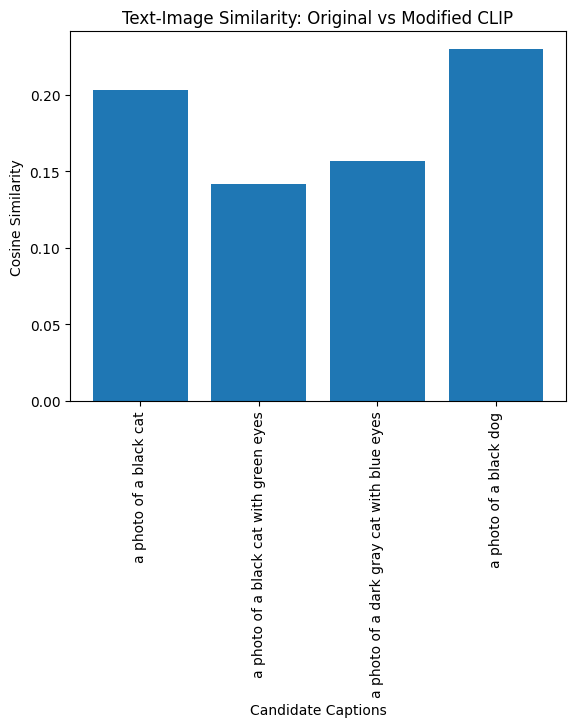

In [228]:
# 텍스트와 이미지 임베딩 추출
image_features = modified_clip_model.get_image_features(pixel_values)
text_features = modified_clip_model.get_text_features(**text_inputs)

# 코사인 유사도 계산
similarities = cosine_similarity(image_features, text_features)

# 유사도 분포 시각화
plt.bar(candidate_captions, similarities.squeeze().tolist())
plt.ylabel("Cosine Similarity")
plt.xlabel("Candidate Captions")
plt.title("Text-Image Similarity: Original vs Modified CLIP")
plt.xticks(rotation=90)
plt.show()


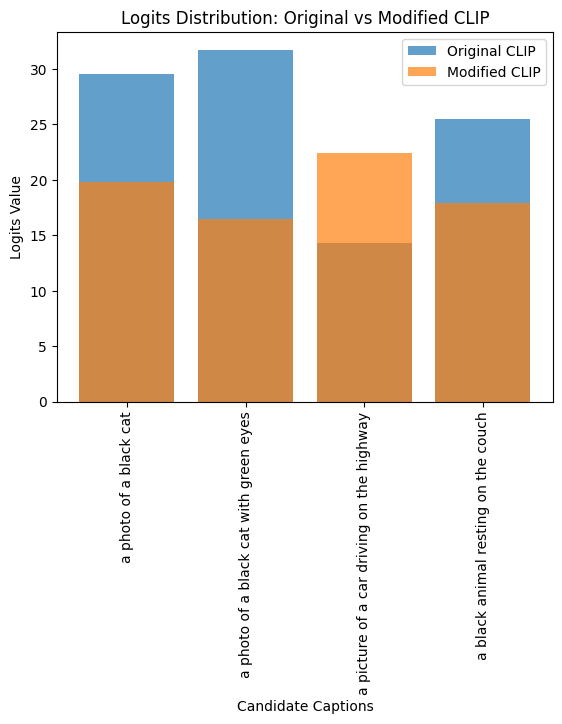

In [214]:
# logits 분포 시각화
plt.bar(candidate_captions, original_logits, alpha=0.7, label="Original CLIP")
plt.bar(candidate_captions, modified_logits, alpha=0.7, label="Modified CLIP")
plt.ylabel("Logits Value")
plt.xlabel("Candidate Captions")
plt.title("Logits Distribution: Original vs Modified CLIP")
plt.xticks(rotation=90)
plt.legend()
plt.show()


In [28]:
# CLIP score 게산
import torch
import torch.nn.functional as F

# 이미지 임베딩 생성
pixel_values = clip_processor(images=image, return_tensors="pt").pixel_values
image_features = clip_model.get_image_features(pixel_values)

# 캡션 임베딩 생성
print(generated_caption)
text_inputs = clip_processor(text=[generated_caption], return_tensors="pt", padding=True)
text_features = clip_model.get_text_features(**text_inputs)

# 임베딩 정규화 (벡터 길이를 1로 만듦)
image_features = F.normalize(image_features, p=2, dim=1)
text_features = F.normalize(text_features, p=2, dim=1)

# 유사도 점수 계산 (코사인 유사도)
similarity_score = (image_features @ text_features.T).item()
print(f"CLIP Similarity Score: {similarity_score}")

a photo of a dog and cat laying on a blanket 
CLIP Similarity Score: 0.25801822543144226
